# Processing DODS Stored NLDAS Data

In [8]:
#################################################
#
# Library 
#

import numpy             as np
import xarray            as xr
import matplotlib        as mpl
import matplotlib.pyplot as plt
import datetime          as datetime
import pandas            as pd
import earthaccess       as earthaccess

import cartopy.crs       as ccrs
import cartopy.feature   as cfeature

#
#################################################

In [10]:
#################################################
#
# Getting Variable Lookup Tables 
#

df_varlut = pd.read_csv(filepath_or_buffer = "./metadata_lookup.csv", index_col="INDEX")

#
#################################################

In [11]:
#################################################
#
# Data Sets and EarthAccess 
#

doi_nldas_noah  = "10.5067/T4OW83T8EXDO"
doi_nldas_force = "10.5067/THUF4J1RLSYG"

auth            = earthaccess.login()

dt              = 3600.

#
#################################################

In [6]:
#################################################
#
# Extract One Day of Data 
#

# This will work if Earthdata prerequisite files have already been generated

results_noah  = earthaccess.search_data(doi      = doi_nldas_noah,
                                        temporal = ('1980-01-01 00:00:00', 
                                                    '1980-01-01 23:59:00')) 

results_force = earthaccess.search_data(doi      = doi_nldas_force,
                                        temporal = ('1980-01-01 00:00:00', 
                                                    '1980-01-01 23:59:00')) 

print("Opening EA-Noah")
%time fs_noah  = earthaccess.open(results_noah)  # Extracts URLs from the results variable

print("")
print("---------------------------")
print("Opening EA-Forcings")
%time fs_force = earthaccess.open(results_force) # Extracts URLs from the results variable

print("")
print("---------------------------")
print("Opening XR-Noah")
%time ds_noah  = xr.open_mfdataset(paths = fs_noah)

print("")
print("---------------------------")
print("Opening XR-Forcings")
%time ds_force = xr.open_mfdataset(paths = fs_force)

#
#################################################

#################################################
#
# Clean and Merge the NOAH and Forcing datasets
#

ds_noah  =  ds_noah.drop_vars(["SMAvail_0_100cm",
                               "SMAvail_0_200cm",
                               "SoilM_0_100cm",
                               "SoilM_0_200cm",
                               "ACond",
                               "CCond",
                               "RCS",
                               "RCT",
                               "RCQ",
                               "RCSOL",
                               "RSmin",
                               "RSMacr"])

ds_force = ds_force.drop_vars(["SWdown",
                               "LWdown",
                               "PotEvap",
                               "Rainf",
                               "CRainf_frac"])

xf_noah_hourly = xr.merge([ds_force, 
                           ds_noah])

del ds_noah
del ds_force


#
#################################################

#################################################
#
# Reshape the Soils Parameters
#


xf_noah_hourly["soil_depth"]      = xf_metadata["soil_depth"]
xf_noah_hourly["soil_thickness"]  = xf_metadata["soil_thickness"]
xf_noah_hourly["soil_depth_bnds"] = xf_metadata["soil_depth_bnds"]

soil_temp = xr.DataArray(data   = np.zeros(shape = [nt_h, 4, ny, nx], 
                                           dtype = np.float32),
                         dims   = ["time","soil_depth","lat","lon"],
                         coords = {"time":xf_noah_hourly["time"],
                                   "soil_depth":xf_metadata["soil_depth"],
                                   "lat":xf_metadata["lat"],
                                   "lon":xf_metadata["lon"]},
                         attrs  = {"description":"Soil Temperature",
                                   "long_name":"Soil Temperature",
                                   "standard_name":"soil_temperature",
                                   "units":"K"})

soil_moist = xr.DataArray(data   = np.zeros(shape = [nt_h, 4, ny, nx], 
                                           dtype = np.float32),
                         dims   = ["time","soil_depth","lat","lon"],
                         coords = {"time":xf_noah_hourly["time"],
                                   "soil_depth":xf_metadata["soil_depth"],
                                   "lat":xf_metadata["lat"],
                                   "lon":xf_metadata["lon"]},
                         attrs  = {"description":"Soil Liquid Water Content",
                                   "long_name":"Soil Liquid Water Content",
                                   "standard_name":"mass_content_of_water_in_soil_layer",
                                   "units":"kg m-2"})

soil_liq  = xr.DataArray(data   = np.zeros(shape = [nt_h, 4, ny, nx], 
                                           dtype = np.float32),
                         dims   = ["time","soil_depth","lat","lon"],
                         coords = {"time":xf_noah_hourly["time"],
                                   "soil_depth":xf_metadata["soil_depth"],
                                   "lat":xf_metadata["lat"],
                                   "lon":xf_metadata["lon"]},
                         attrs  = {"description":"Soil Liquid Water Content",
                                   "long_name":"Soil Liquid Water Content",
                                   "standard_name":"liquid_water_content_of_soil_layer",
                                   "units":"kg m-2"})

xf_noah_hourly["liquid_water_content_of_soil_layer"]  = soil_liq
xf_noah_hourly["mass_content_of_water_in_soil_layer"] = soil_moist
xf_noah_hourly["soil_temperature"]                    = soil_temp

soil_liq.values[:,0,:,:] = xf_noah_hourly["SMLiq_0_10cm"].values
soil_liq.values[:,1,:,:] = xf_noah_hourly["SMLiq_10_40cm"].values
soil_liq.values[:,2,:,:] = xf_noah_hourly["SMLiq_40_100cm"].values
soil_liq.values[:,3,:,:] = xf_noah_hourly["SMLiq_100_200cm"].values 

soil_moist.values[:,0,:,:] = xf_noah_hourly["SoilM_0_10cm"].values
soil_moist.values[:,1,:,:] = xf_noah_hourly["SoilM_10_40cm"].values
soil_moist.values[:,2,:,:] = xf_noah_hourly["SoilM_40_100cm"].values
soil_moist.values[:,3,:,:] = xf_noah_hourly["SoilM_100_200cm"].values 

soil_temp.values[:,0,:,:] = xf_noah_hourly["SoilT_0_10cm"].values
soil_temp.values[:,1,:,:] = xf_noah_hourly["SoilT_10_40cm"].values
soil_temp.values[:,2,:,:] = xf_noah_hourly["SoilT_40_100cm"].values
soil_temp.values[:,3,:,:] = xf_noah_hourly["SoilT_100_200cm"].values 

del xf_noah_hourly["SoilT_0_10cm"]
del xf_noah_hourly["SoilT_10_40cm"]
del xf_noah_hourly["SoilT_40_100cm"]
del xf_noah_hourly["SoilT_100_200cm"]

del xf_noah_hourly["SoilM_0_10cm"]
del xf_noah_hourly["SoilM_10_40cm"]
del xf_noah_hourly["SoilM_40_100cm"]
del xf_noah_hourly["SoilM_100_200cm"]

del xf_noah_hourly["SMLiq_0_10cm"]
del xf_noah_hourly["SMLiq_10_40cm"]
del xf_noah_hourly["SMLiq_40_100cm"]
del xf_noah_hourly["SMLiq_100_200cm"]

#
#################################################

#################################################
#
# Change Variable Metadata for Hourly Data
#

for index, row in df_varlut.iterrows():
    xf_noah_hourly  = xf_noah_hourly.rename_vars(name_dict = {index:row["new_name"]})
    xf_noah_hourly[row["new_name"]].attrs["long_name"]     = row["long_name"]
    xf_noah_hourly[row["new_name"]].attrs["description"]   = row["long_name"]
    xf_noah_hourly[row["new_name"]].attrs["standard_name"] = row["standard_name"]
    xf_noah_hourly[row["new_name"]].attrs["units"]         = row["units_in"]

    if ("vmax" in xf_noah_hourly[row["new_name"]].attrs):
        del xf_noah_hourly[row["new_name"]].attrs["vmax"]
    if ("vmin" in xf_noah_hourly[row["new_name"]].attrs):
        del xf_noah_hourly[row["new_name"]].attrs["vmin"]
print("--------")

#
#################################################

#################################################
#
# Aggregate Hourly to Daily Data
#

print("Aggregating Daily Data")

xf_noah_daily = xf_noah_hourly.drop_vars("time_bounds").coarsen(time=24).sum(skipna=False)
for index, row in df_varlut.drop(axis="columns", index=["time","time_bnds"]).iterrows():
    xf_noah_daily[row["new_name"]].attrs["long_name"]     = row["long_name"]
    xf_noah_daily[row["new_name"]].attrs["description"]   = row["long_name"]
    xf_noah_daily[row["new_name"]].attrs["standard_name"] = row["standard_name"]
    xf_noah_daily[row["new_name"]].attrs["units"]         = row["units_in"]

df_varlut_mean = df_varlut[ df_varlut["Aggregation"] ==     "MEAN" ]["new_name"].to_list()
df_varlut_sum  = df_varlut[ df_varlut["Aggregation"] ==      "SUM" ]["new_name"].to_list()
df_varlut_int  = df_varlut[ df_varlut["Aggregation"] == "INTEGRAL" ]["new_name"].to_list()

for variable in df_varlut_int:
    xf_noah_daily[variable].values  = xf_noah_daily[variable].values * dt

for variable in df_varlut_mean:
    xf_noah_daily[variable].values  = xf_noah_daily[variable].values / 24.


#
#########################################################

Opening EA-Noah


QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

CPU times: user 167 ms, sys: 50.5 ms, total: 217 ms
Wall time: 3.88 s

---------------------------
Opening EA-Forcings


QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

CPU times: user 94 ms, sys: 24 ms, total: 118 ms
Wall time: 1.98 s

---------------------------
Opening XR-Noah
CPU times: user 5.82 s, sys: 1.04 s, total: 6.86 s
Wall time: 51.7 s

---------------------------
Opening XR-Forcings
CPU times: user 2.32 s, sys: 368 ms, total: 2.68 s
Wall time: 30.3 s
--------
Aggregating Daily Data


In [23]:
xf_noah_hourly

<xarray.Dataset> Size: 469MB
Dimensions:                                                                           (
                                                                                       time: 24,
                                                                                       bnds: 2,
                                                                                       lat: 224,
                                                                                       lon: 464,
                                                                                       soil_depth: 4)
Coordinates:
  * lon                                                                               (lon) float32 2kB ...
  * lat                                                                               (lat) float32 896B ...
  * time                                                                              (time) datetime64[ns] 192B ...
  * soil_depth                                                                        (soil_depth) float32 16B ...
Dimensions without coordinates: bnds
Data variables: (12/41)
    time_bounds                                                                       (time, bnds) datetime64[ns] 384B dask.array<chunksize=(1, 2), meta=np.ndarray>
    air_temperature                                                                   (time, lat, lon) float32 10MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    specific_humidity                                                                 (time, lat, lon) float32 10MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    air_pressure                                                                      (time, lat, lon) float32 10MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    eastward_wind                                                                     (time, lat, lon) float32 10MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    northward_wind                                                                    (time, lat, lon) float32 10MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    ...                                                                                ...
    water_volume_transport_in_river_channel                                           (time, lat, lon) float32 10MB dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    soil_layer_thickness                                                              (soil_depth) float32 16B ...
    soil_layer_depth_bnds                                                             (soil_depth, bnds) float32 32B ...
    liquid_water_content_of_soil_layer                                                (time, soil_depth, lat, lon) float32 40MB ...
    mass_content_of_water_in_soil_layer                                               (time, soil_depth, lat, lon) float32 40MB ...
    soil_temperature                                                                  (time, soil_depth, lat, lon) float32 40MB ...
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FORA0125_H_2.0
    title:                  NLDAS Primary Forcing Data L4 Hourly 0.125 x 0.12...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

In [28]:
xf_noah_daily2 = xf_noah_hourly.drop_vars("time_bounds").coarsen(time=24).sum(skipna=False)

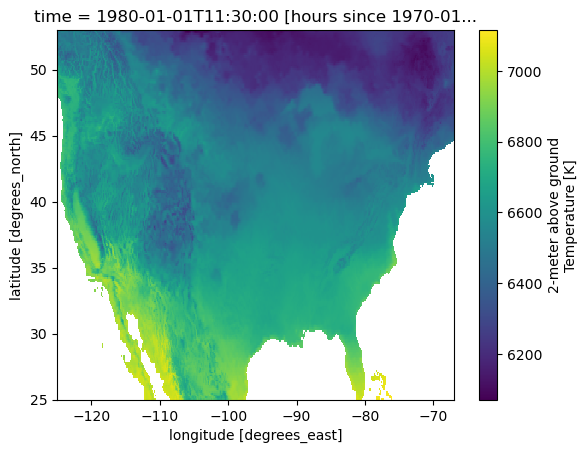

In [29]:
xf_noah_daily2["air_temperature"].plot()

In [91]:
#########################################################
#
# Write to File
#

daily_date       = pd.to_datetime(xf_noah_daily["time"])[0]
output_directory = daily_date.strftime('%Y/%m/')
filedate         = daily_date.strftime('%Y-%m-%d')
fileout          = "NLDAS_NOAH_DAILY_"+filedate+".nc"

del xf_noah_daily["time"].attrs["units"]

xf_noah_daily.to_netcdf(path           = fileout,
                       unlimited_dims  = "time",
                       encoding        ={"time":{"units":     "seconds since 1970-01-01 00:00:00",
                                                 "dtype":     np.float64}})

#
#########################################################